In [30]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="ior"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    # pass 


In [31]:
def load_ior_summary_list(json_file: Path):
    data = json.loads(json_file.read_text())
    return [
        {
            'Version': data['Version'],
            'Began': data['Began'],
            'Command line': data['Command line'],
            'Machine': data['Machine'],
            'Finished': data['Finished'],
            **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
            **{f"max_{k}": v for k, v in test["max"].items()},
            **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
            **{f"Options_{k}": v for k, v in test["Options"].items()},
            **{f'summary_{k}': v for k, v in data['summary'][index].items()},
            **{f'result_{k}': v for k, v in result.items()},
            'iorIteration': iteration,
        }
        for index, test in enumerate(data['tests'])
        for iteration, results in enumerate(test["Results"]) # iteration ?
        for result in results
    ]
# load_ior_summary_list(Path(f"../raw/{BENCHMARK_NAME}/2023.11.16-19.27.41/2023.11.16-20.03.19-92963.nqsv-bank-conflict-1/ior_summary_1.json"))


In [32]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

wpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
rpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
extract_hook_pmembb_time_max(rpath)


{'createTime': 14.976, 'freeTime': 0.023, 'loadTime': 0.005}

In [33]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

job_group = (
    ("ior-pmembb/2024.01.23-15.20.41-default", {"storageSystem": "PMEMBB"}),
    ("ior-pmembb/2024.01.23-15.22.18-default", {"storageSystem": "PMEMBB"}),
    ("ior-pmembb/2024.01.24-12.44.18-default", {"storageSystem": "PMEMBB"}), # remain 100 node job
    # ("ior-beeond/2024.02.19-16.30.42-default", {}),
    ("ior-lustre/2024.02.19-12.11.41-default", {}),
    # ("ior-beeond/2024.02.21-11.41.39-32-64node", {}),
    # ("ior-beeond/2024.02.22-14.42.30-8G-32node", {}),
    # ("ior-beeond/2024.02.22-17.54.41-4G-64node", {}),
    # ("ior-chfs/2024.02.22-18.40.41-default", {}),
    ("ior-unifyfs/2024.02.25-00.47.21-default", {}),
    # ("ior-chfs/2024.02.26-12.41.00-local", {}),
    # ("ior-chfs/2024.02.26-12.41.00-local", {"storageSystem": "CHFS-local"}),
    ("ior-lustre/2024.03.08-13.32.07-100", {}),
    # ("ior-chfs/2024.03.08-13.29.30-100", {}),
    ("ior-unifyfs/2024.03.08-13.28.47-100", {}),
    # ("ior-beeond/2024.02.28-06.53.51-setpattern", {}),
    # ("ior-beeond/2024.03.08-13.28.14-100", {}),
    # ("ior-beeond/2024.03.10-12.43.26-1-64", {}),
    ("ior-beeond/2024.03.10-13.02.17-default", {}),
    ("ior-chfs/2024.03.13-10.47.36-ppn8-100", {}),
    ("ior-chfs/2024.03.13-10.54.26-ppn8", {}),
    ("ior-beeond/2024.03.13-11.01.27-default", {}),
)

def job_dirs(job_group_dir: str):
    dir = RAW_BASEDIR / job_group_dir
    return (f.resolve() for f in dir.iterdir() if f.is_dir())

re_timestamp = re.compile(r'([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})')
def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None

re_runid = re.compile(r"_([0-9]+)\.json")
def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None

def load_nodelist(job_dir: Path):
    with(job_dir / f"nodelist").open() as f:
        return list(map(lambda s: s.strip(), f.readlines()))

src = []
for job_group_dir,metadata in job_group:
    for job_dir in job_dirs(job_group_dir):
        try:
            job_start = {"job_start": parse_job_start_timestamp(job_dir)}
            job_nodelist = {"nodelist": load_nodelist(job_dir)}
        except Exception as e:
            print(f"{job_dir}, {e}")
        for summary_file in job_dir.glob("ior_summary_*.json"):
            try:
                runid = get_runid(summary_file)
                # runtype = get_runtype(summary_file)
                job_summary_list = load_ior_summary_list(summary_file)
                job_params_file = job_dir / f"job_params_{runid}.json"
                job_params = json.loads(job_params_file.read_text())
                pmembb_time = extract_hook_pmembb_time_max(job_dir / f"ior_stderr_{runid}.txt")
                for job_summary in job_summary_list:
                    src.append({
                        **default_metadata,
                        **job_start,
                        **job_nodelist,
                        **job_params,
                        **job_summary,
                        **pmembb_time,
                        "runid": runid,
                        **metadata,
                    })
            except FileNotFoundError as e:
                print(e)
            except Exception as e:
                print(f'{summary_file}, {e}')

df_src = (
    pd.DataFrame(src)
    .assign(odirect=lambda x: x["Command line"].str.contains("--posix.odirect"))
    .assign(strided=lambda x: x["summary_transferSize"] == x["summary_blockSize"])
    .rename({
        "summary_bwMaxMIB": "bw",
        "summary_MeanTime": "time",
        "summary_segmentCount": "segmentCount",
        "summary_blockSize": "blockSize",
        "summary_transferSize": "transferSize",
        "summary_operation": "operation",
        "Parameters_filePerProc": "fpp",
        "Parameters_reorderTasks": "reorder",
        "summary_API": "api",
        "result_access": "access",
        "result_bwMiB": "bwMiB",
        "result_openTime": "openTime",
        "result_wrRdTime": "wrRdTime",
        "result_closeTime": "closeTime",
        "result_totalTime": "totalTime",
    }, axis=1)
    .astype({"fpp": bool, "reorder": bool,})
    .assign(bwGB=lambda x: x["bwMiB"] * 2**20 / 10**9)
)
df_src["label"] = np.select([
    (df_src["access"] == "write"),
    (df_src["access"] == "read") & (df_src["reorder"] == True),
    (df_src["access"] == "read") & (df_src["reorder"] == False),
], ["Write", "Read (remote)", "Read (local)"])


df_src.head()


/work/0/NBB/hiraga/work/mpiio-pmembb/raw/ior-pmembb/2024.01.23-15.20.41-default/2024.01.24-09.00.05-166928.nqsv-100/ior_summary_13.json, Expecting value: line 1 column 1 (char 0)


,job_start,nodelist,nnodes,ppn,np,jobid,runid,pmem_path,pmem_size,lustre_version,lustre_stripe_size,lustre_stripe_count,spack_env_name,Version,Began,Command line,Machine,Finished,test_TestID,test_StartTime,test_Path,test_Capacity,test_Used Capacity,test_Inodes,test_Used Inodes,max_readMiB,max_readMB,Parameters_testID,Parameters_refnum,Parameters_api,Parameters_platform,Parameters_testFileName,Parameters_hintsFileName,Parameters_deadlineForStonewall,Parameters_stoneWallingWearOut,Parameters_maxTimeDuration,Parameters_outlierThreshold,Parameters_options,Parameters_dryRun,Parameters_nodes,Parameters_memoryPerTask,Parameters_memoryPerNode,Parameters_tasksPerNode,Parameters_repetitions,Parameters_multiFile,Parameters_interTestDelay,Parameters_fsync,Parameters_fsyncperwrite,Parameters_useExistingTestFile,Parameters_showHints,Parameters_uniqueDir,Parameters_individualDataSets,Parameters_singleXferAttempt,Parameters_readFile,Parameters_writeFile,fpp,reorder,Parameters_reorderTasksRandom,Parameters_reorderTasksRandomSeed,Parameters_randomOffset,Parameters_checkWrite,Parameters_checkRead,Parameters_preallocate,Parameters_useFileView,Parameters_setAlignment,Parameters_storeFileOffset,Parameters_useSharedFilePointer,Parameters_useStridedDatatype,Parameters_keepFile,Parameters_keepFileWithError,Parameters_quitOnError,Parameters_verbose,Parameters_data packet type,Parameters_setTimeStampSignature/incompressibleSeed,Parameters_collective,Parameters_segmentCount,Parameters_transferSize,Parameters_blockSize,Options_api,Options_apiVersion,Options_test filename,Options_access,Options_type,Options_segments,Options_ordering in a file,Options_ordering inter file,Options_nodes,Options_tasks,Options_clients per node,Options_repetitions,Options_xfersize,Options_blocksize,Options_aggregate filesize,operation,api,summary_TestID,summary_ReferenceNumber,segmentCount,blockSize,transferSize,summary_numTasks,summary_tasksPerNode,summary_repetitions,summary_filePerProc,summary_reorderTasks,summary_taskPerNodeOffset,summary_reorderTasksRandom,summary_reorderTasksRandomSeed,bw,summary_bwMinMIB,summary_bwMeanMIB,summary_bwStdMIB,summary_OPsMax,summary_OPsMin,summary_OPsMean,summary_OPsSD,time,summary_xsizeMiB,access,bwMiB,result_blockKiB,result_xferKiB,result_iops,result_latency,openTime,wrRdTime,closeTime,totalTime,iorIteration,createTime,freeTime,loadTime,storageSystem,Options_task offset,max_writeMiB,max_writeMB,saveTime,iorAccessPattern,Options_stonewallingTime,Options_stoneWallingWearOut,summary_StoneWallTime,summary_StoneWallbwMeanMIB,fi_universe_size,UNIFYFS_LOG_VERBOSITY,UNIFYFS_LOGIO_SPILL_DIR,UNIFYFS_LOGIO_SPILL_SIZE,UNIFYFS_LOGIO_SHMEM_SIZE,UNIFYFS_LOGIO_CHUNK_SIZE,UNIFYFS_MARGO_TCP,UNIFYFS_MARGO_CLIENT_TIMEOUT,UNIFYFS_MARGO_SERVER_TIMEOUT,UNIFYFS_MARGO_SERVER_POOL_SIZE,UNIFYFS_MARGO_CLIENT_POOL_SIZE,UNIFYFS_RUNSTATE_DIR,UNIFYFS_SERVER_MAX_APP_CLIENTS,UNIFYFS_SERVER_INIT_TIMEOUT,UNIFYFS_SERVER_LOCAL_EXTENTS,UNIFYFS_CLIENT_LOCAL_EXTENTS,UNIFYFS_CLIENT_NODE_LOCAL_EXTENTS,chfs_chunk_size,chfs_log_priority,chfs_nthreads,chfs_niothreads,chfs_rdma_thresh,chfs_async_access,chfs_lookup_local,chfs_version,odirect,strided,bwGB,label
0,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,8,/dev/dax0.0,0.0,2.12.9_ddn38,1048576.0,1.0,mpiio-pmembb,3.3.0,Wed Jan 24 01:23:16 2024,ior -a MPIIO -l timestamp -g -G -1401473791 -k...,Linux bnode001,Wed Jan 24 01:23:29 2024,0,Wed Jan 24 01:23:16 2024,/work/0/NBB/hiraga/work/mpiio-pmembb/backend/i...,100.0 TiB,72.3%,5682.7 Mi,3.4%,4.901099e+06,5.139175e+06,0,0,MPIIO,bnode(Linux),/work/0/NBB/hiraga/work/mpiio-pmembb/backend/i...,(null),0,0,0,0,(null),0,64,0,0,48,1,0,0,1,0,0,0,0,0,0,1,0,False,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,t,-1401473791,0,1,524288,21474836480,MPIIO,(3.1),/work/0/NBB/hiraga/work/mpiio-pmembb/backend/i...,single-shared-file,independent,1,sequential,no tasks offsets,64,3072,48,1,524288 bytes,20 GiB,60 TiB,read,MPIIO,0,0,1,21474836480,524288,3072,48,1,0,0,1,0,0,4.901

In [34]:
df = df_src

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display(df.columns.to_list())

(
    df[[
        "storageSystem",
        "spack_env_name",
        "nnodes",
        # "segmentCount",
        # "blockSize",
        "transferSize",
        "lustre_stripe_count",
        "api",
        "label",
        "access",
        "reorder",
        "bwGB",
        "openTime",
        "wrRdTime",
        "closeTime",
        "totalTime",
        "createTime",
        "freeTime",
        "loadTime",
        "saveTime",
        "loadTime",
    ]]
    .head()
)


,storageSystem,spack_env_name,nnodes,transferSize,lustre_stripe_count,api,label,access,reorder,bwGB,openTime,wrRdTime,closeTime,totalTime,createTime,freeTime,loadTime,saveTime,loadTime
0,PMEMBB,mpiio-pmembb,64,524288,1.0,MPIIO,Read (local),read,False,5139.174919,0.2317,12.5886,0.0486,12.8368,16.614,0.052,0.016,NaN,0.016
1,PMEMBB,mpiio-pmembb,64,262144,1.0,MPIIO,Read (remote),read,True,1541.638842,0.3018,42.4550,0.0383,42.7926,16.154,0.024,0.015,NaN,0.015
2,PMEMBB,mpiio-pmembb,64,2097152,1.0,MPIIO,Write,write,False,1562.943721,0.3964,41.7731,0.0639,42.2093,16.242,0.068,NaN,0.016,NaN
3,PMEMBB,mpiio-pmembb,64,1048576,1.0,MPIIO,Read (local),read,False,4990.550762,0.4269,12.7469,0.0357,13.2191,16.663,0.055,0.016,NaN,0.016
4,PMEMBB,mpiio-pmembb,64,2097152,1.0,MPIIO,Read (remote),read,True,1540.631507,0.3080,42.5002,0.0419,42.8206,16.269,0.024,0.012,NaN,0.012


<Axes: xlabel='storageSystem,spack_env_name,nnodes,access,reorder,label'>

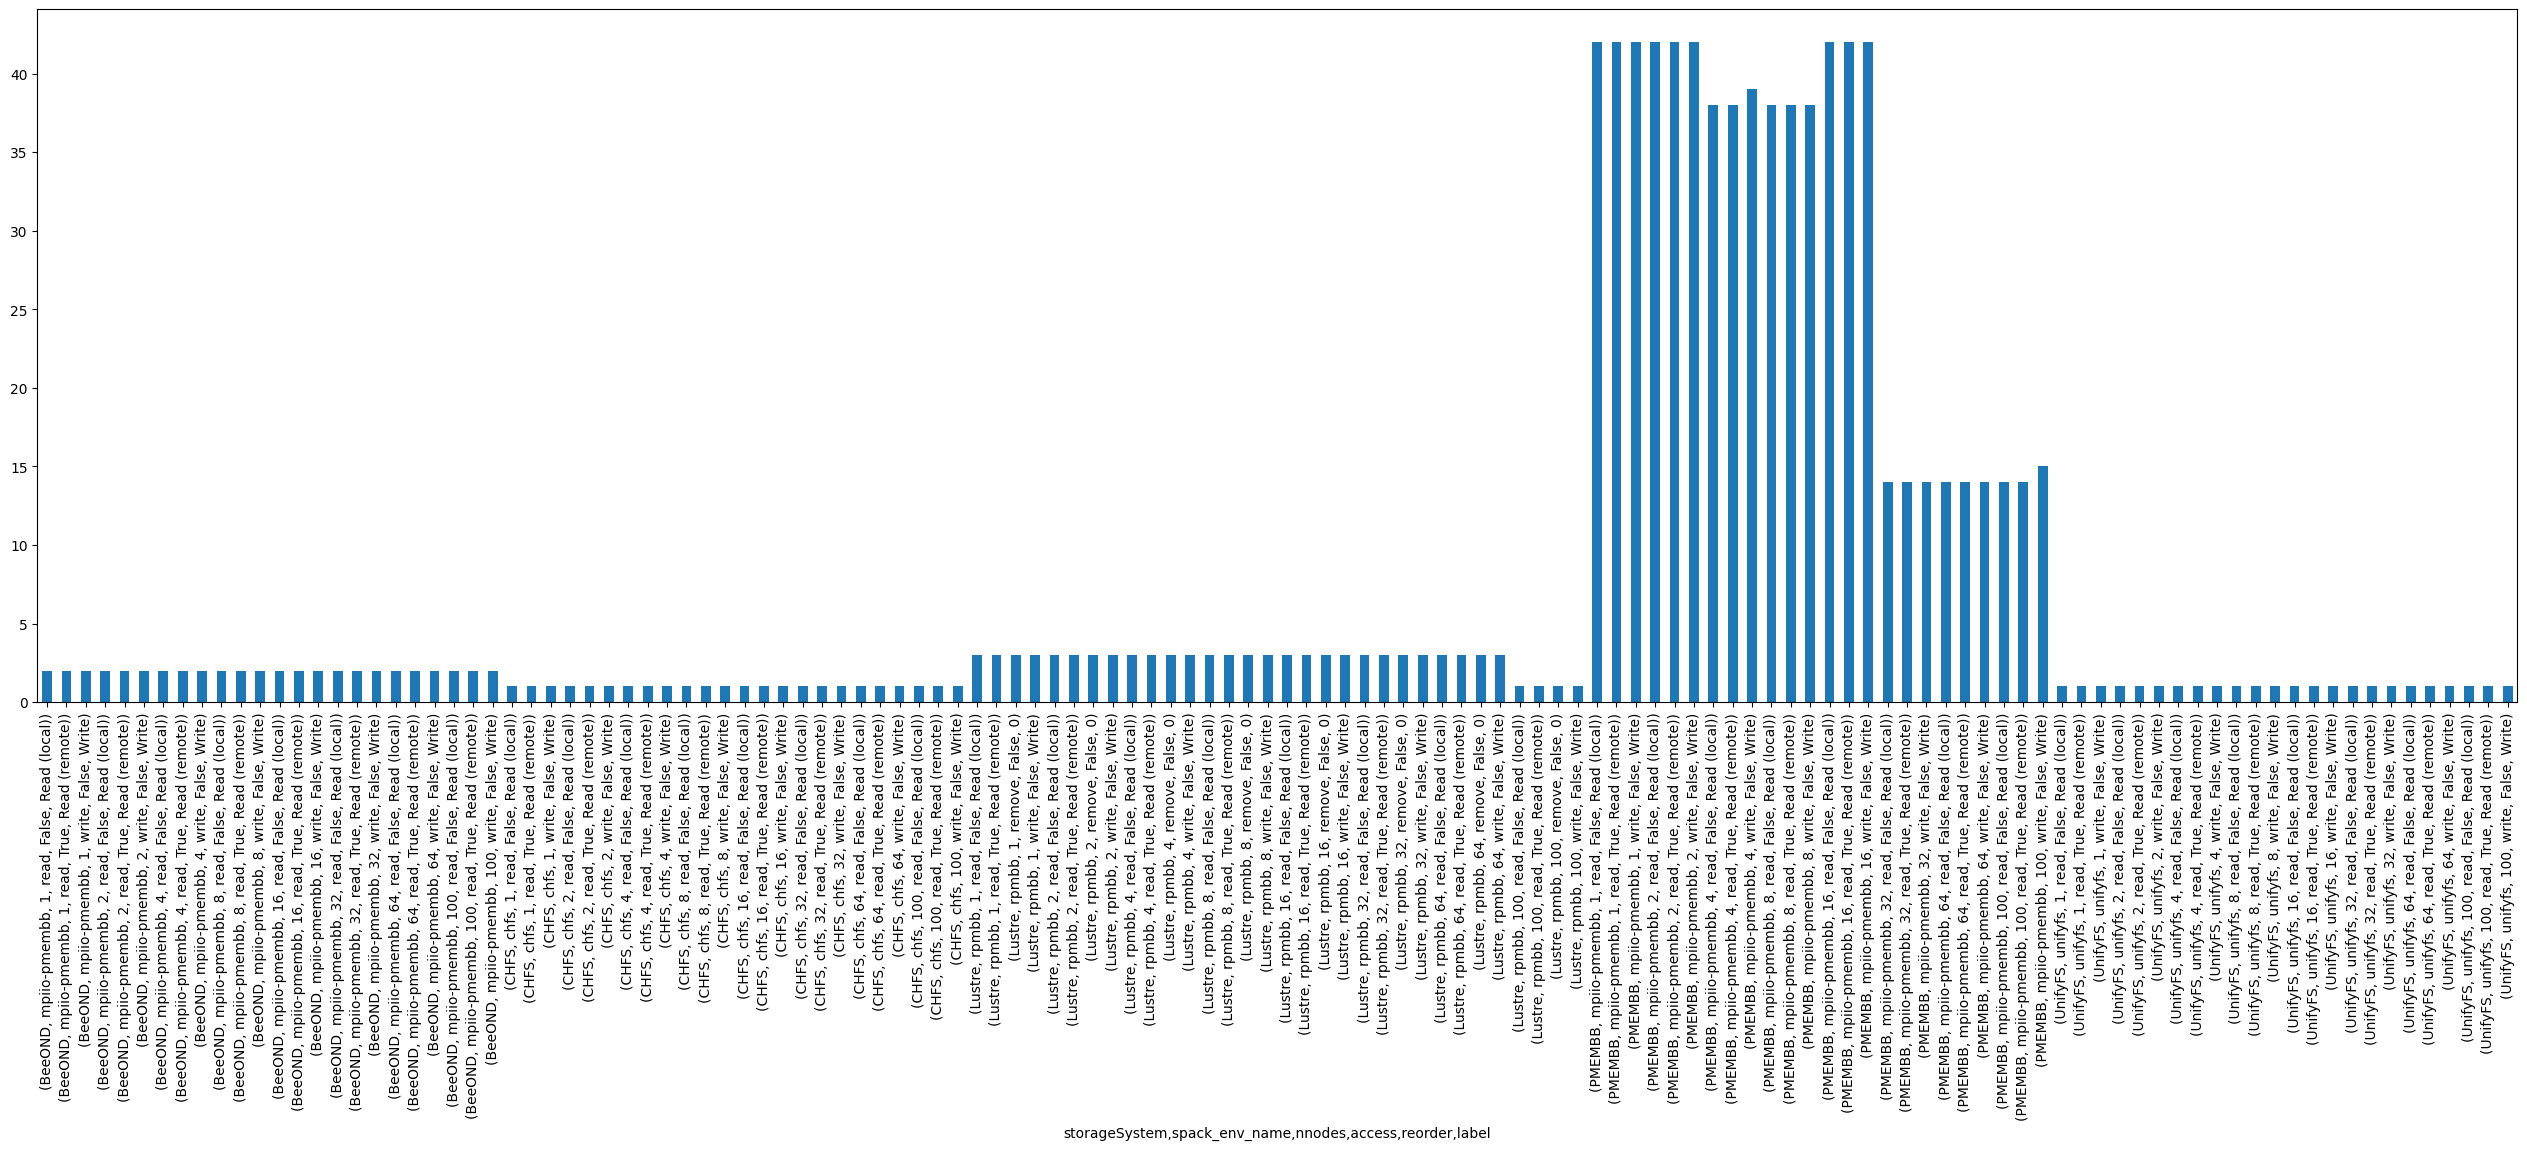

In [35]:
df = df_src
same_setting_columns = [
    "storageSystem",
    "spack_env_name",
    "nnodes",
    "access",
    "reorder",
    "label",
    # "transferSize",
    # "lustre_stripe_count",
]
same_setting_grouper = df.groupby(same_setting_columns)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# display(same_setting_grouper.size())
(
    same_setting_grouper
    .size()
    .plot(figsize=(32, 9), kind="bar")
)


86.23150365828711
27.741294696595457
read False Read (local)


storageSystem,Lustre,BeeOND,CHFS,UnifyFS,PMEMBB
nnodes,,,,,
1,4.227516,8.953188,18.737703,0.320005,83.593321
2,8.406153,18.508202,27.309305,0.639729,169.882509
4,16.900505,34.822606,47.530438,1.276016,328.375277
8,33.082390,66.990708,88.318357,2.561366,654.396892
16,50.175458,131.169084,168.341503,5.105858,1303.361282
32,49.087766,258.663676,336.107214,10.204339,2550.720071
64,48.936631,510.092902,663.865516,20.343275,5139.174919
100,51.260485,792.676442,1031.533672,31.804309,7750.595630


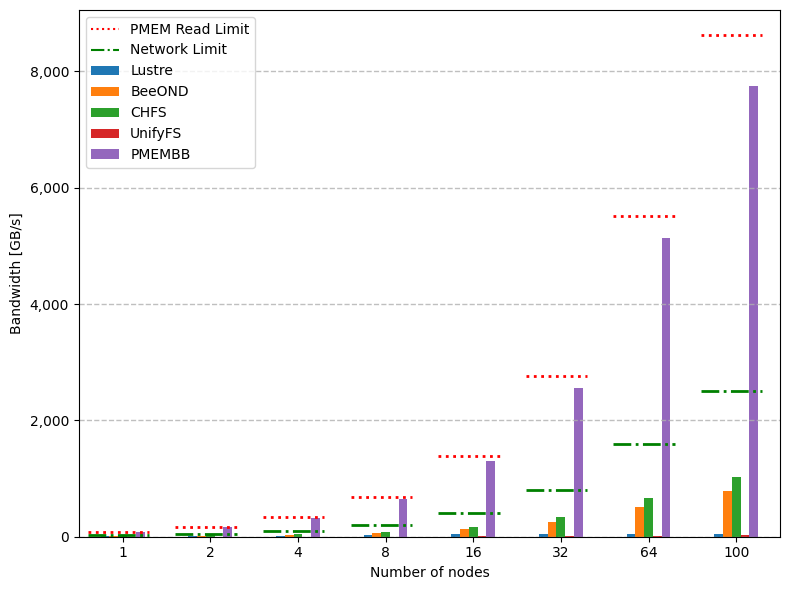

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


read True Read (remote)


storageSystem,Lustre,BeeOND,CHFS,UnifyFS,PMEMBB
nnodes,,,,,
2,8.476103,18.512007,27.333108,0.613928,48.580417
4,16.726129,34.870098,47.473784,1.205152,97.089789
8,33.028621,67.029253,88.435970,2.291010,193.858457
16,50.018964,119.576244,169.383707,4.699442,387.072398
32,49.035771,211.903184,333.926856,9.446521,773.253691
64,48.870996,323.199884,662.325881,14.542146,1541.638842
100,50.695758,712.177709,1028.557438,13.398797,2387.744699


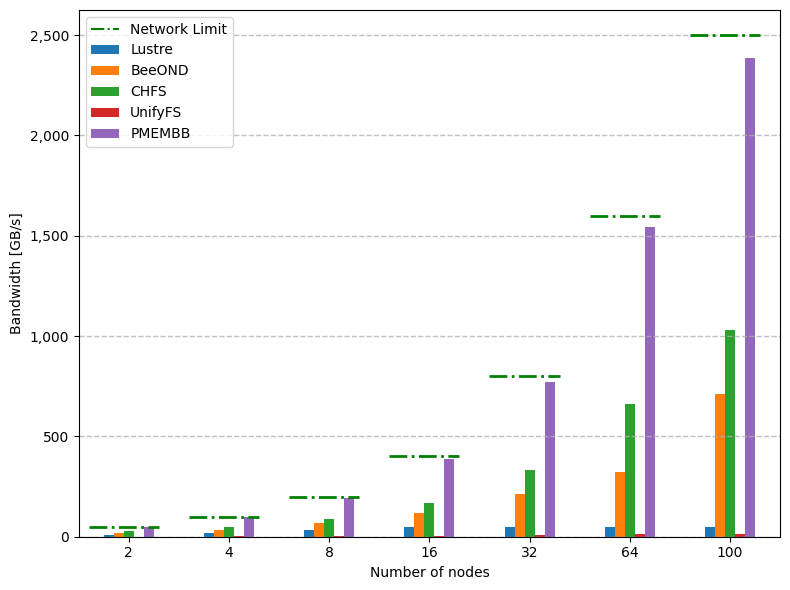

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


write False Write


storageSystem,Lustre,BeeOND,CHFS,UnifyFS,PMEMBB
nnodes,,,,,
1,2.197092,3.499816,7.009261,12.277756,26.470330
2,4.401067,5.405237,10.870913,23.935503,52.864778
4,8.718904,9.543697,21.071447,48.983521,103.653041
8,17.154205,18.238852,42.241413,92.477583,201.975732
16,30.660943,36.118496,80.481491,188.030302,398.962319
32,38.641920,70.800639,157.353946,367.686901,799.270147
64,40.398911,129.520148,316.677678,724.160303,1594.014120
100,38.959190,198.484181,481.825975,1113.183539,2470.947638


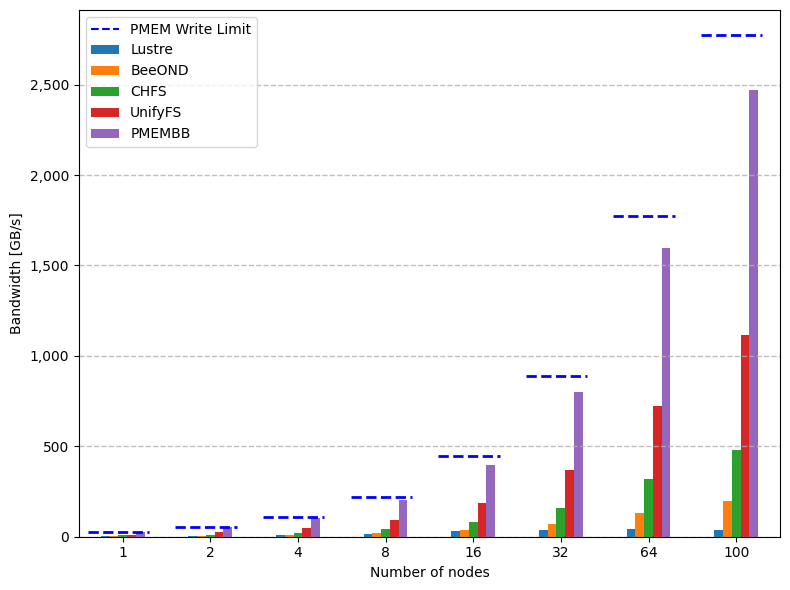

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [36]:
def network_limit(nnodes, bandwidth_per_node=25):
    return nnodes * bandwidth_per_node

PMEM_READ_LIMIT_PER_NODE = 80.309346 * 2**30 / 10**9
PMEM_WRITE_LIMIT_PER_NODE = 25.836094 * 2**30 / 10**9
print(PMEM_READ_LIMIT_PER_NODE)
print(PMEM_WRITE_LIMIT_PER_NODE)

def pmem_read_limit(nnodes):
    return nnodes * PMEM_READ_LIMIT_PER_NODE

def pmem_write_limit(nnodes):
    return nnodes * PMEM_WRITE_LIMIT_PER_NODE

df = (
    same_setting_grouper["bwGB"].max()
    # .agg({
    #     "bw": "max",
    #     "time": "min",
    # })
    .reset_index()
    # .assign(bwGB=lambda x: x["bw"] * 2**20 / 10**9)
    # .assign(transferSizeH=lambda x: x["transferSize"].apply(pretty_fmt))
    # .query(f"transferSize == {2*2**20}")
    .query("not (storageSystem == 'PMEMBB' and spack_env_name !='mpiio-pmembb')")
    .query("access != 'remove'")
    .query("not (access == 'read' and reorder == True and nnodes == 1)")
    .query("nnodes <= 100")
)

# display(df)

# return

for (access, reorder, label), df_sub, in df.groupby(["access", "reorder", "label"]):
    print(access, reorder, label)
    # for value in ["bw", "time"]:
    for value in ["bwGB"]:
        # df_plot = df_sub.pivot(index="transferSize", columns=["nnodes"], values=value)
        df_plot = (
            df_sub
            .pivot(index="nnodes", columns=["storageSystem"], values=value)
            # .loc[:, [pretty_fmt(256 * 2**x) for x in range(0, 14)]]
        )
        # df_plot.columns = df_plot.columns.get_level_values(1)
        df_plot = df_plot.loc[:, [
            "Lustre",
            "BeeOND",
            "CHFS",
            # "CHFS-local",
            "UnifyFS",
            "PMEMBB",
        ]]
        # .rename({
        #     "BeeOND": "BeeOND on PMEM",
        # }, axis=1)

        display(df_plot)

        fig = plt.figure(figsize=(8, 6), dpi=100)
        fig.patch.set_alpha(1)
        # ax=fig.add_subplot()

        ax = df_plot.plot(
            ax=fig.add_subplot(),
            kind="bar",
            # kind="line",
            # xlabel="Transfer size [B]",
            xlabel="Number of nodes",
            ylabel="Bandwidth [GB/s]" if value == "bwGB" else "Elapsed time [sec]",
            # style=".-",
            rot=0,
        )
        # if reorder:
        # バーグラフのx軸の目盛りの位置を取得
        xticks = ax.get_xticks()
        # print(xticks)
        
        network_limits = [network_limit(nnodes) for nnodes in df_plot.index]
        pmem_read_limits = [pmem_read_limit(nnodes) for nnodes in df_plot.index]
        pmem_write_limits = [pmem_write_limit(nnodes) for nnodes in df_plot.index]
        
        # 各ノード数に対して限界線をプロット
        if access == 'read' and reorder == False:
            for xtick, limit in zip(xticks, pmem_read_limits):
                ax.axhline(y=limit, xmin=(xtick+0.1)/len(xticks), xmax=(xtick + 0.8)/len(xticks), color='red', linestyle=':', linewidth=2)
            ax.plot([], [], linestyle=":", color="red", label="PMEM Read Limit")
        if access == 'write':
            for xtick, limit in zip(xticks, pmem_write_limits):
                ax.axhline(y=limit, xmin=(xtick+0.1)/len(xticks), xmax=(xtick + 0.8)/len(xticks), color='blue', linestyle='--', linewidth=2)
            ax.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit")
        if access == 'read':
            for xtick, limit in zip(xticks, network_limits):
                ax.axhline(y=limit, xmin=(xtick+0.1)/len(xticks), xmax=(xtick + 0.8)/len(xticks), color='green', linestyle='-.', linewidth=2)
            ax.plot([], [], linestyle="-.", color="green", label="Network Limit")
        

        # ax.set_title(f"IOR {label}")
        # ax.set_xscale("log", base=2)
        # ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
        ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
        # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

        # legend_title = ax.get_legend().get_title().get_text()
        # ax.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        # ax.legend(title="Transfer size")
        ax.legend(title="")
        plt.tight_layout()

        fig.show()
        plt.show()
        save(fig, F"ior_comp_{access}_{'remote' if reorder else 'local'}_{value}")
